In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

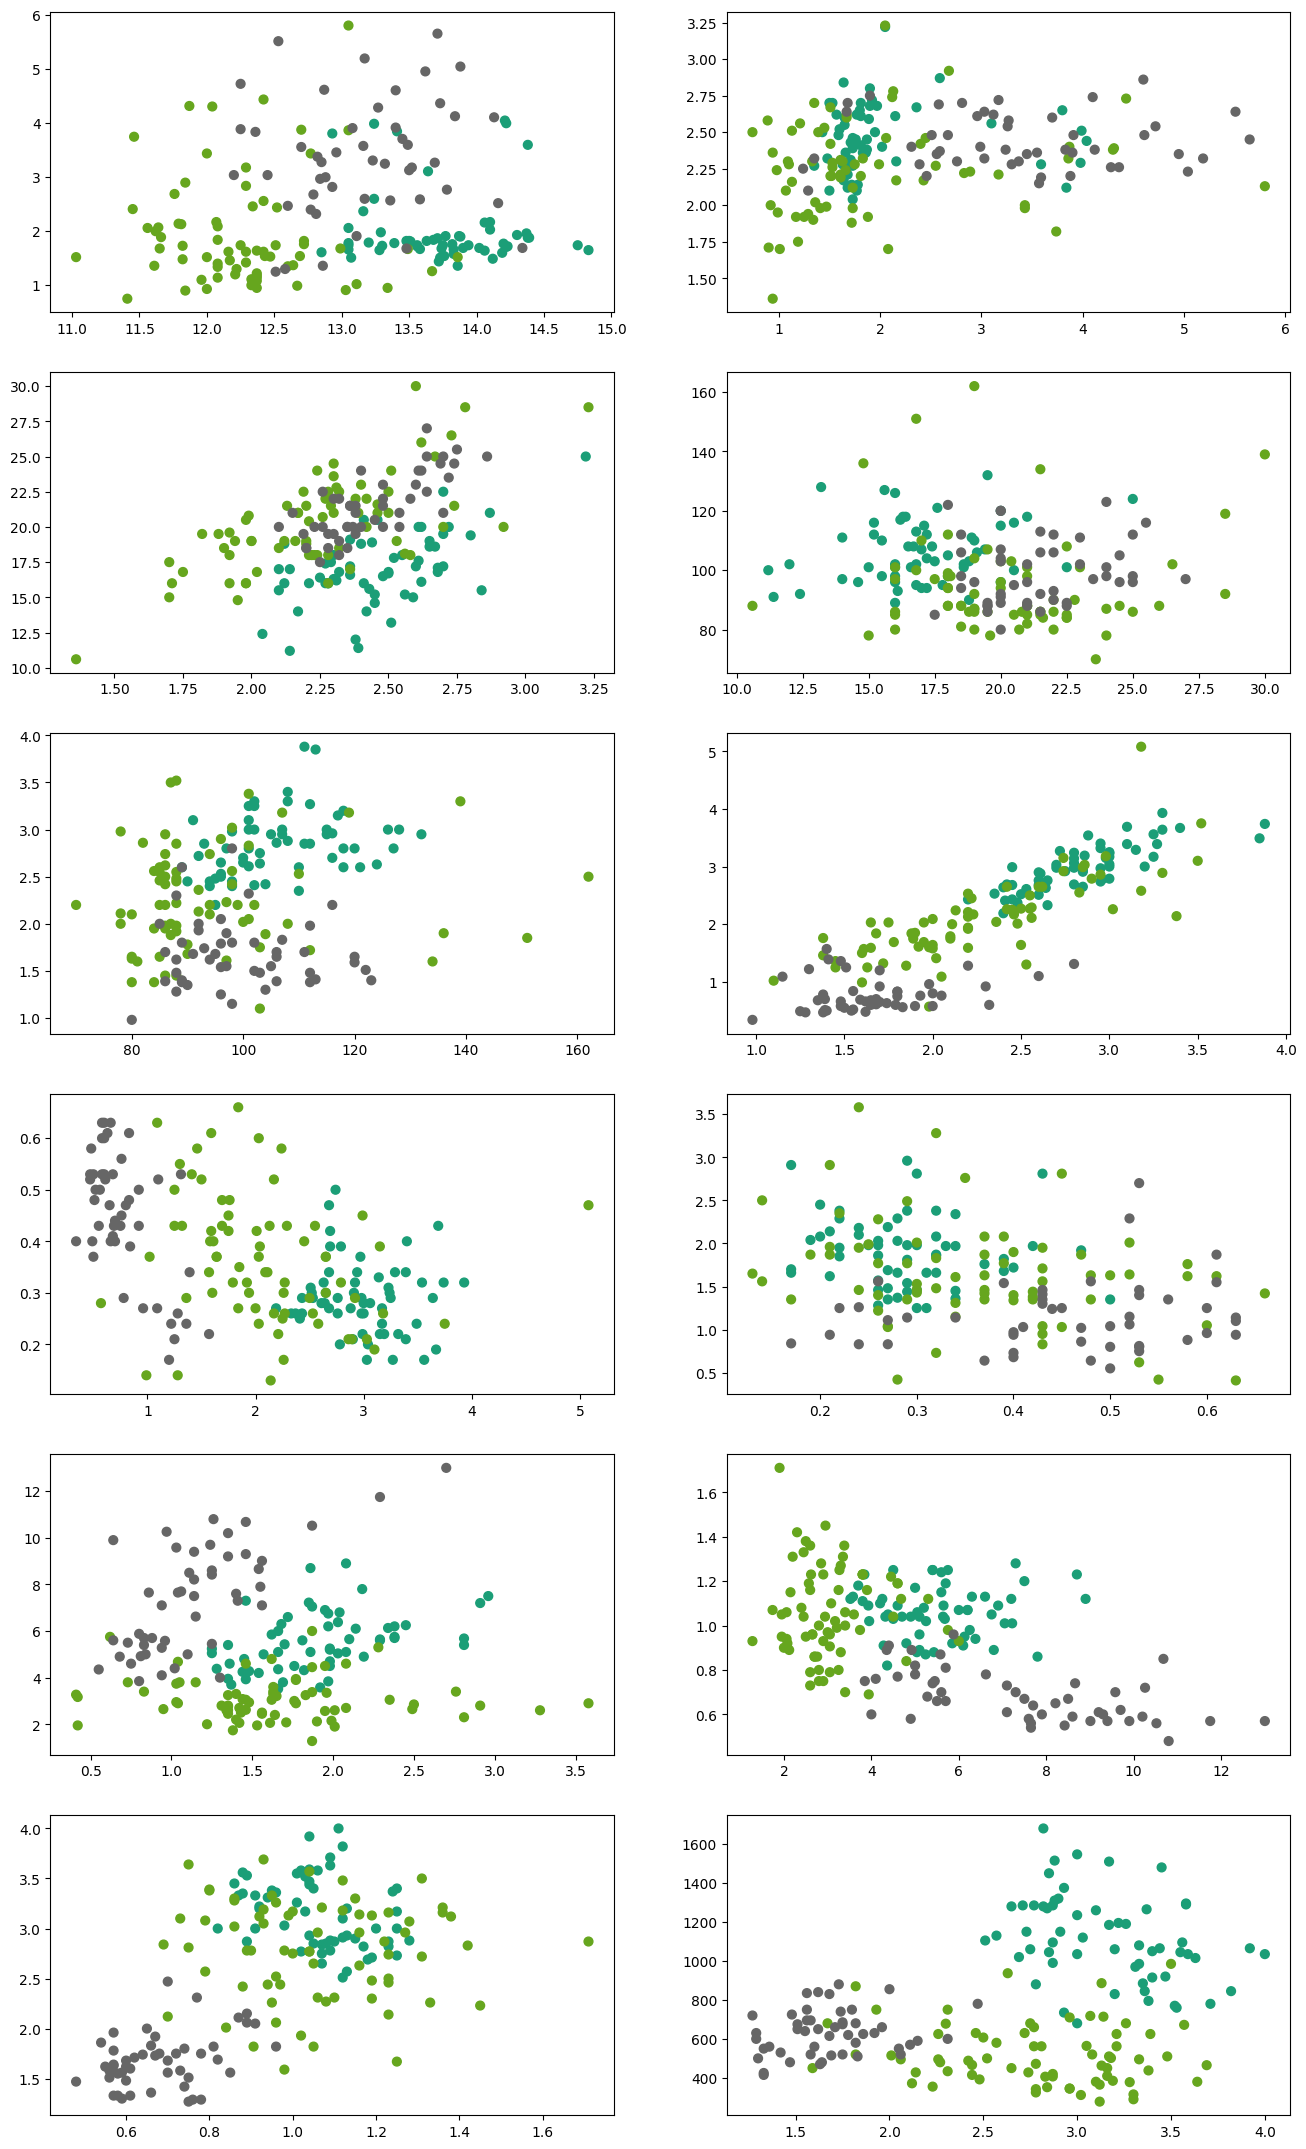

In [31]:
np.random.seed(0)
X, y = sklearn.datasets.load_wine(return_X_y=True)
plt.figure(figsize=(16, 32))
for i in range(X.shape[1]-1):
    plt.subplot(7, 2, i+1)
    plt.scatter(X[:,i], X[:,i+1], s=40, c=y, cmap=plt.cm.Dark2)
plt.show()
# 為了方便繪圖，只取兩個Featuer
X = X[:, :2]

In [32]:
def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()]) # 這邊就是對所有區域做預測
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)

In [33]:
clf = sklearn.linear_model.LogisticRegressionCV()
clf.fit(X, y)

LogisticRegressionCV()

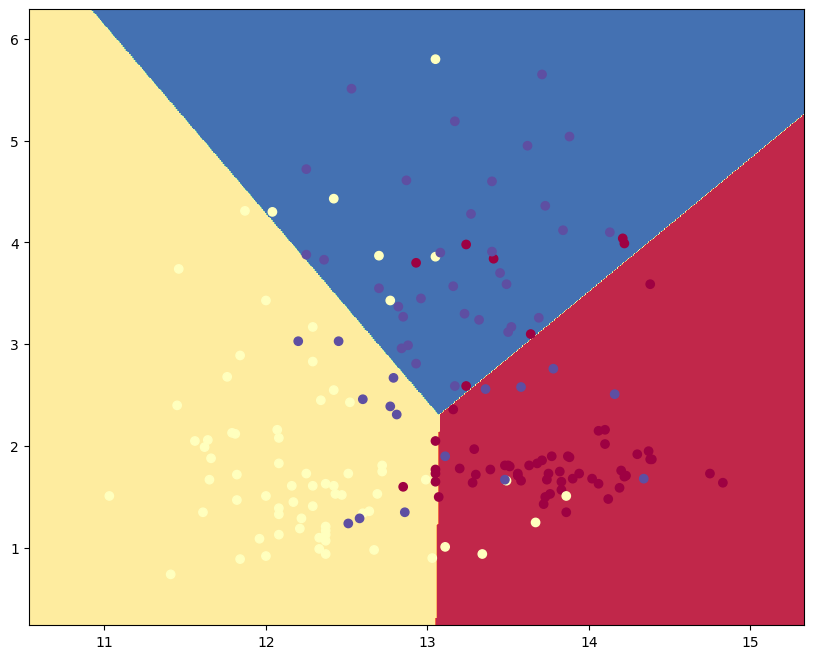

In [34]:
plot_decision_boundary(lambda x: clf.predict(x))

##### Implement

In [60]:
num_examples = len(X)
nn_input_dim = 2
nn_output_dim = 3

epsilon = 0.001 # learning rate
reg_lambda = 0.01 # regularization

##### Upsample or Downsample

In [190]:
# Upsample
def upsample(X, y):
    uni, arg = np.unique(y, return_counts=True)
    maximum = np.max(arg)
    X_new = X
    y_new = y
    for i in range(len(uni)):
        if arg[i] < maximum:
            mean = np.nanmean(X[y==i], axis=0)
            std = np.nanstd(X[y==i], axis=0)
            X_new = np.concatenate((X_new, np.random.normal(loc=mean, scale=std, size=(maximum-arg[i], X.shape[-1]))), axis=0)
            y_new = np.concatenate((y_new, np.zeros((maximum-arg[i], ))+i), axis=0)
    return X_new, y_new.astype(np.int32)

X_up, y_up = upsample(X, y)

def downsample(X, y):
    uni, arg = np.unique(y, return_counts=True)
    minimum = np.min(arg)
    X_new = X[y==np.argmin(arg)]; 
    y_new = y[y==np.argmin(arg)]
    for i in range(len(uni)):
        if arg[i] > minimum:
            idx = np.argwhere(y==i).reshape(-1)
            np.random.shuffle(idx)
            X_i = X[idx[:minimum]]
            y_i = y[idx[:minimum]]

            X_new = np.concatenate((X_new, X_i), axis=0)
            y_new = np.concatenate((y_new, y_i), axis=0)
    return X_new, y_new.astype(np.int32)
X_dn, y_dn = downsample(X, y)

##### Loss function

In [191]:
# Input layer(n[0], 2): A[l] - hidden layer1 Z(n[1], 1) W(n[1], n[0]) A(n[0], 1) b(n[1], 1) - hidden layer2 - output layer
# layer1: W1, b1; layer2: W2, b2; output layer: W3, b3
def calculate_loss(model):
    W1, b1, W2, b2, W3, b3 = \
        model['W1'], model['b1'], model['W2'], model['b2'], model['W3'], model['b3']
    
    z1 = X.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    a2 = np.tanh(z2)
    z3 = a2.dot(W3) + b3
    exp_scores = np.exp(z3)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    corect_logprob = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(corect_logprob) # 將所有nm合計
    # regulatization
    data_loss += reg_lambda/2 * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    return 1./num_examples * data_loss # 總和平均


In [192]:
def predict(model, x):
    W1, b1, W2, b2, W3, b3 = \
        model['W1'], model['b1'], model['W2'], model['b2'], model['W3'], model['b3']
    
    z1 = x.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    a2 = np.tanh(z2)
    z3 = a2.dot(W3) + b3
    exp_scores = np.exp(z3)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1) # 每一個nm的最大預測值就是y-hat


In [222]:
# This function learns parameters for the neural network and returns the model.
# - nn_hdim: Number of nodes in the hidden layer
# - num_passes: Number of passes through the training data for gradient descent
# - print_loss: If True, print the loss every 1000 iterations

# This function learns parameters for the neural network and returns the model.
# - nn_hdim: Number of nodes in the hidden layer
# - num_passes: Number of passes through the training data for gradient descent
# - print_loss: If True, print the loss every 1000 iterations

def build_mini_batch_model(X, y, nn_hdim, lr=0.01, num_passes=20000, batch=1, print_loss=False):

    # Initialize the parameters to random values. We need to learn these.
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, int(nn_hdim*.5)) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, int(nn_hdim*.5)))
    W3 = np.random.randn(int(nn_hdim*.5), nn_output_dim) / np.sqrt(int(nn_hdim*.5))
    b3 = np.zeros((1, nn_output_dim))

    model = {}
    epsilon = lr
    LOSS = []
    # Gradient descent.
    for i in range(0, num_passes): # for each batch
        for j in range(0, len(X)-batch, batch):
            # Forward
            z1 = X[j:j+batch].dot(W1) + b1
            a1 = np.where(z1>0, z1, np.zeros_like(z1))
            z2 = a1.dot(W2) + b2
            a2 = np.where(z2>0, z2, np.zeros_like(z2))
            z3 = a2.dot(W3) + b3
            exp_scores = np.exp(z3)
            probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

            # Back
            delta4 = probs
            delta4[range(batch), y[j:j+batch]] -= 1 # delta == dZ, 這邊等於Y-hat - Y(有Y==1的地方才-1) 
            dW3 = (a2.T).dot(delta4) # a1.T.dot(Z3)
            db3 = np.sum(delta4, axis=0, keepdims=True)
            delta3 = delta4.dot(W3.T) * np.where(a2>0, np.zeros_like(a2)+1,  np.zeros_like(a2))#(1 - np.power(a2, 2))
            dW2 = (a1.T).dot(delta3)
            db2 = np.sum(delta3, axis=0, keepdims=True)
            delta2 = delta3.dot(W2.T) * np.where(a1>0, np.zeros_like(a1)+1,  np.zeros_like(a1))#(1 - np.power(a1, 2))
            dW1 = np.dot(X[j:j+batch].T, delta2)
            db1 = np.sum(delta2, axis=0, keepdims=True) # 這邊範例沒使用keepdims
            # Regularization
            dW3 += reg_lambda * W3
            dW2 += reg_lambda * W2
            dW1 += reg_lambda * W1

            # Gradient descent 這邊才是真正的調整權重
            W1 += -epsilon * dW1
            b1 += -epsilon * db1
            W2 += -epsilon * dW2
            b2 += -epsilon * db2
            W3 += -epsilon * dW3
            b3 += -epsilon * db3

        # Assign new parameters to the model
        model = {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2, 'W3': W3, 'b3': b3}
        if i % 5 == 0:
            epsilon *= 0.999
        if print_loss and i % 1000 == 0:
            print("Loss after iteration %i: %f" %(i, calculate_loss(model)))
        LOSS.append(calculate_loss(model))
    return model
    

Loss after iteration 0: 1.247550
Loss after iteration 1000: 1.124015
Loss after iteration 2000: 1.095893
Loss after iteration 3000: 1.078194
Loss after iteration 4000: 1.066504
Loss after iteration 5000: 1.058360
Loss after iteration 6000: 1.052177
Loss after iteration 7000: 1.047368
Loss after iteration 8000: 1.043707
Loss after iteration 9000: 1.041567
Loss after iteration 10000: 1.039939
Loss after iteration 11000: 1.038627
Loss after iteration 12000: 1.037645
Loss after iteration 13000: 1.037002
Loss after iteration 14000: 1.036491
Loss after iteration 15000: 1.036080
Loss after iteration 16000: 1.035748
Loss after iteration 17000: 1.035479
Loss after iteration 18000: 1.035260
Loss after iteration 19000: 1.035082


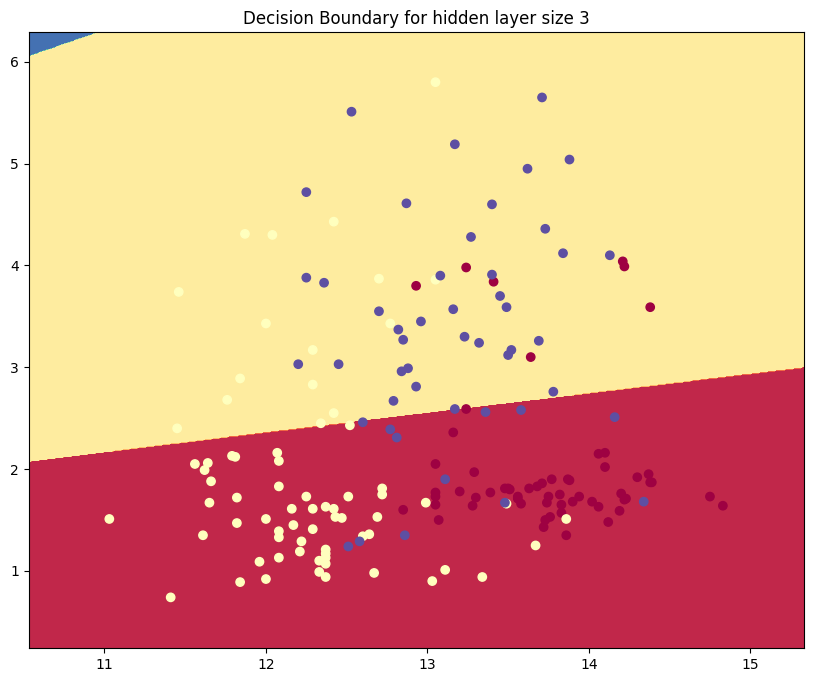

In [231]:
model = build_mini_batch_model(X=X_dn, y=y_dn, nn_hdim=32, lr=0.00001, batch=100, print_loss=True)

plot_decision_boundary(lambda x: predict(model, x))
plt.title("Decision Boundary for hidden layer size 3")
plt.show()